问题 2 考虑商超以品类为单位做补货计划，请分析各蔬菜品类的销售总量与成本加成定价的关系，并给出各蔬菜品类未来一周(2023 年 7 月 1-7 日)的日补货总量和定价策略， 使得商超收益最大。
* 思路：通过成本加成定价算出预期利润率，通过不同时期的利润率去分析单位利润率与销量之间的关系，潜在的关系为，利润率越高，销量越低
* 需要注意的是，我们分析的是各蔬菜品类而非单品的销量与成本加成定价关系，通过成本加成定价我们可以得到利润率，一个关键问题是如何通过品类下的不同单品利润率聚会得到总的品类的利润率，再在品类上去分析销售总量与利润率之间的关系

In [330]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# 设置中文显示字体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 支持显示负号
plt.rcParams['axes.unicode_minus'] = False

# 忽略警告信息
import warnings
warnings.filterwarnings("ignore")

# 导入随机森林回归器
from sklearn.ensemble import RandomForestRegressor
# 导入交叉验证工具
from sklearn.model_selection import cross_val_score

# 导入时间序列分析工具
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# 导入数据归一化工具
from sklearn.preprocessing import MinMaxScaler

# 导入自相关和偏自相关图工具
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 导入自相关性检验工具
from statsmodels.stats.diagnostic import acorr_ljungbox


In [131]:
df1 = pd.read_excel('附件1.xlsx')
df2 = pd.read_excel('附件2.xlsx')
df3 = pd.read_excel('附件3.xlsx')

In [137]:
## 合并名为 df2 和 df1 的两个 DataFrame
df = pd.merge(df2, df1)

# 初始化一个空列表，用于存储批发价格
ls = []

# 遍历 df 中的单品编码和销售日期
for code, date in zip(df['单品编码'], df['销售日期']):
    # 从 df3 中根据日期和单品编码获取批发价格，并将其添加到列表 ls 中
    ls.append(df3[(df3.日期 == date) & (df3.单品编码 == code)]['批发价格(元/千克)'].values[0])

# 将批发价格列表添加到 df 中作为新的一列，列名为 '批发价格'
df['批发价格'] = ls
df

,销售日期,扫码销售时间,单品编码,销量(千克),销售单价(元/千克),销售类型,是否打折销售,单品名称,分类编码,分类名称,批发价格
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,销售,否,泡泡椒(精品),1011010504,辣椒类,4.32
1,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,销售,否,泡泡椒(精品),1011010504,辣椒类,4.32
2,2020-07-01,09:21:55.556,102900005117056,0.277,7.6,销售,否,泡泡椒(精品),1011010504,辣椒类,4.32
3,2020-07-01,09:22:01.274,102900005117056,0.132,7.6,销售,否,泡泡椒(精品),1011010504,辣椒类,4.32
4,2020-07-01,09:41:09.342,102900005117056,0.198,7.6,销售,否,泡泡椒(精品),1011010504,辣椒类,4.32
...,...,...,...,...,...,...,...,...,...,...,...
878498,2023-06-21,16:30:43.092,102900011036686,1.000,3.9,销售,否,木耳菜(份),1011010101,花叶类,1.37
878499,2023-06-23,18:47:46.777,102900011036686,1.000,3.9,销售,否,木耳菜(份),1011010101,花叶类,1.22
878500,2023-06-27,20:48:10.998,102900011036686,1.000,3.9,销售,是,木耳菜(份),1011010101,花叶类,1.46
878501,2023-06-29,19:14:35.799,102900011036686,1.000,2.3,销售,是,木耳菜(份),1011010101,花叶类,1.71


In [138]:
# 排除退货商品和打折商品，构建每个单品的成本、价格、销量和成本利润率

# 从 DataFrame 中筛选出销售类型为“销售”且是否打折销售为“否”的记录
df = df[(df.是否打折销售 == '否') & (df.销售类型 == '销售')]

# 使用 groupby 方法按单品编码和销售日期对数据进行分组聚合
sales = df.groupby(['单品编码', '销售日期']).agg({"销量(千克)": [np.sum], '批发价格': ['mean'], '销售单价(元/千克)': [np.mean]})

# 重命名聚合后的列名
sales.columns = ['总销量', '批发价格', '销售价格']

# 计算总利润，即销售价格减去批发价格乘以总销量
sales['总利润'] = (sales['销售价格'] - sales['批发价格']) * sales['总销量']

# 计算成本利润率，即销售价格减去批发价格除以批发价格
sales['成本利润率'] = (sales['销售价格'] - sales['批发价格']) / sales['批发价格']

# 初始化一个空列表，用于存储分类名称
ls = []

# 遍历聚合后的数据的索引
for i in sales.index:
    # 通过单品编码从 df1 中获取对应的分类名称，并添加到列表中
    ls.append(df1[df1.单品编码 == i[0]]['分类名称'].values[0])

# 将分类名称列表添加到 sales DataFrame 中作为新的一列
sales['分类名称'] = ls

# 重置索引，使 DataFrame 更整洁
index = sales.index
sales = sales.reset_index()

# 分别提取单品编码和销售日期作为两列
sales['单品编码'] = [i[0] for i in index]
sales['销售日期'] = [i[1] for i in index]

# 最终的 DataFrame 包含了每个单品的总销量、批发价格、销售价格、总利润、成本利润率和分类名称
sales

,单品编码,销售日期,总销量,批发价格,销售价格,总利润,成本利润率,分类名称
0,102900005115168,2020-10-30,6.427,3.00,5.0,12.8540,0.666667,花叶类
1,102900005115168,2020-10-31,7.251,3.00,5.0,14.5020,0.666667,花叶类
2,102900005115168,2020-11-01,13.126,3.00,4.6,21.0016,0.533333,花叶类
3,102900005115168,2020-12-04,5.972,1.60,3.0,8.3608,0.875000,花叶类
4,102900005115168,2021-03-03,11.568,1.60,5.0,39.3312,2.125000,花叶类
...,...,...,...,...,...,...,...,...
46075,106973990980123,2022-07-23,1.000,1.67,2.5,0.8300,0.497006,食用菌
46076,106973990980123,2022-07-25,7.000,1.87,2.5,4.4100,0.336898,食用菌
46077,106973990980123,2022-07-26,2.000,1.90,2.5,1.2000,0.315789,食用菌
46078,106973990980123,2022-07-28,6.000,2.02,2.5,2.8800,0.237624,食用菌


In [139]:
# 通过加权的思想计算每个品类的价格、成本和利润率

# 初始化空列表用于存储每个销售记录的归一化系数和值
ls = []
values = []

# 遍历销售数据中的唯一分类名称
for i in sales['分类名称'].unique():
    # 从销售数据中筛选出当前分类名称的记录
    tem = sales[sales.分类名称 == i]
    
    # 遍历当前分类记录中的唯一销售日期
    for o in tem['销售日期'].unique():
        # 筛选出当前分类和销售日期的记录
        t = tem[tem.销售日期 == o]
        
        # 计算当前销售日期内总销量的和
        s = t['总销量'].sum()
        
        # 计算并记录当前销售记录的归一化系数
        for z in t['总销量'].values:
            ls.append(z / s)
        
        # 记录当前销售记录的所有字段值
        for v in t.values:
            values.append(v)

# 创建一个新的DataFrame，列名与原始销售数据相同，填充每个字段的值
sales = pd.DataFrame(values, columns=sales.columns)

# 添加归一化系数列，表示每个销售记录的权重
sales['归一化系数'] = ls

# 计算加权批发价格、加权销售价格和加权成本利润率
sales['加权批发价格'] = sales['归一化系数'] * sales['批发价格']
sales['加权销售价格'] = sales['归一化系数'] * sales['销售价格']
sales['加权成本利润率'] = sales['归一化系数'] * sales['成本利润率']

# 根据分类名称和销售日期对加权数据进行分组和聚合
sales_pro = sales.groupby(['分类名称', '销售日期']).agg({"总销量": [np.sum], '总利润': [np.sum], '加权批发价格': [np.sum],
                                                        '加权销售价格': [np.sum], '加权成本利润率': [np.sum]})

# 重命名聚合后的列名
sales_pro.columns = ['总销量', '总利润', '加权批发价格', '加权销售价格', '加权成本利润率']

# 重置索引，使DataFrame更整洁
index = sales_pro.index
sales_pro = sales_pro.reset_index()

# 提取分类名称和销售日期作为两列
sales_pro['分类名称'] = [i[0] for i in index]
sales_pro['销售日期'] = [i[1] for i in index]

# 最终的DataFrame包含了每个品类在每个销售日期的总销量、总利润、加权批发价格、加权销售价格和加权成本利润率
sales_pro

,分类名称,销售日期,总销量,总利润,加权批发价格,加权销售价格,加权成本利润率
0,水生根茎类,2020-07-01,4.850,25.49812,9.234161,14.491505,0.706978
1,水生根茎类,2020-07-02,4.600,20.48956,7.093748,11.548000,0.710128
2,水生根茎类,2020-07-03,4.410,19.35990,5.610000,10.000000,0.782531
3,水生根茎类,2020-07-04,5.439,42.52497,14.015119,21.833646,0.688605
4,水生根茎类,2020-07-05,4.019,18.40702,5.420000,10.000000,0.845018
...,...,...,...,...,...,...,...
6468,食用菌,2023-06-26,27.582,64.70880,4.218664,6.564716,0.530185
6469,食用菌,2023-06-27,25.708,60.13720,4.226498,6.565738,0.543177
6470,食用菌,2023-06-28,51.742,82.62280,3.086181,4.683004,0.470561
6471,食用菌,2023-06-29,43.314,72.32760,3.278580,4.948423,0.460978


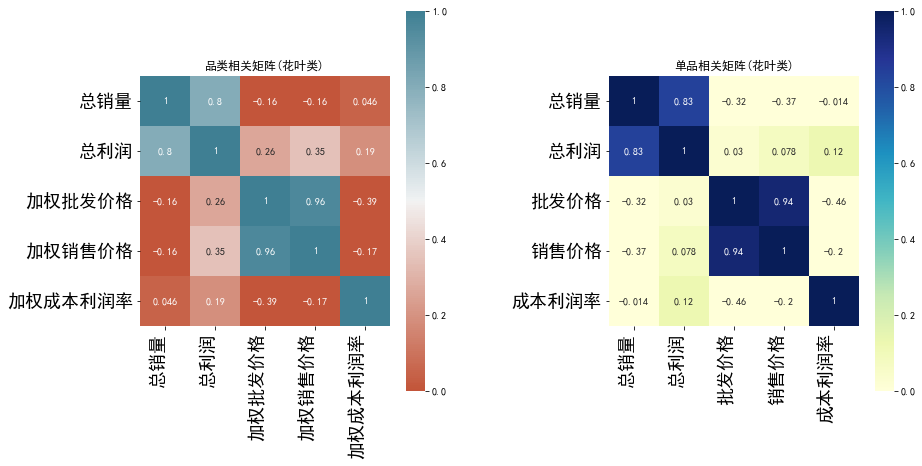

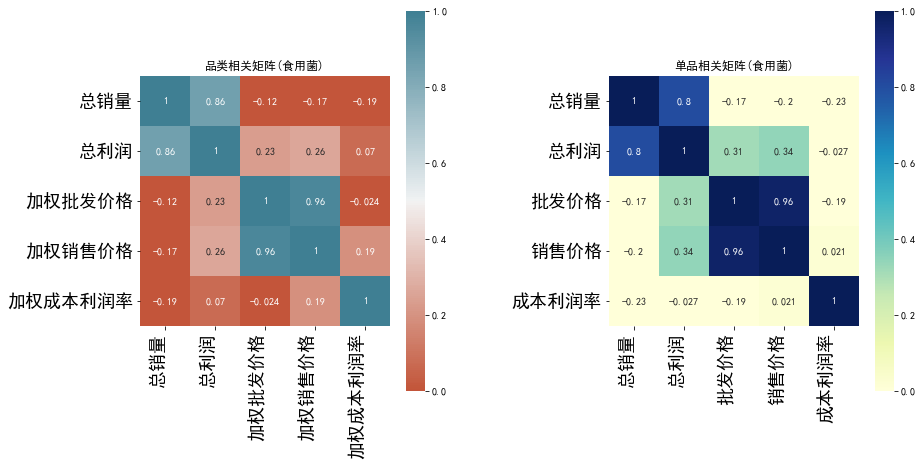

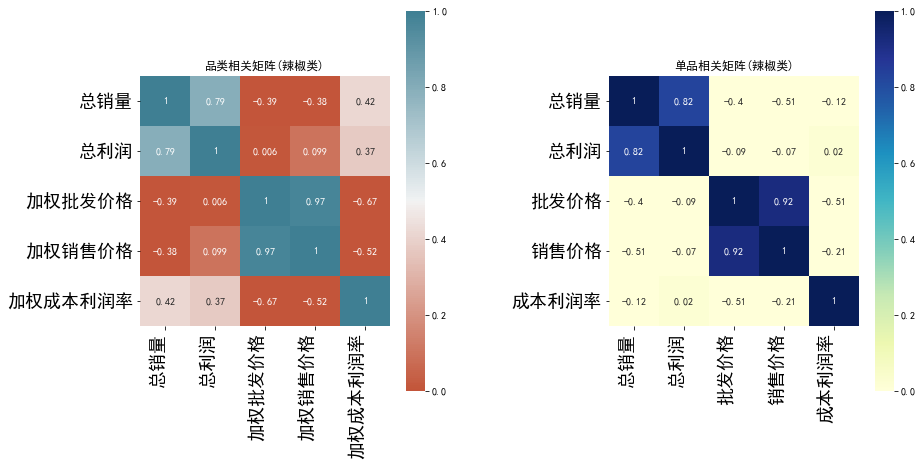

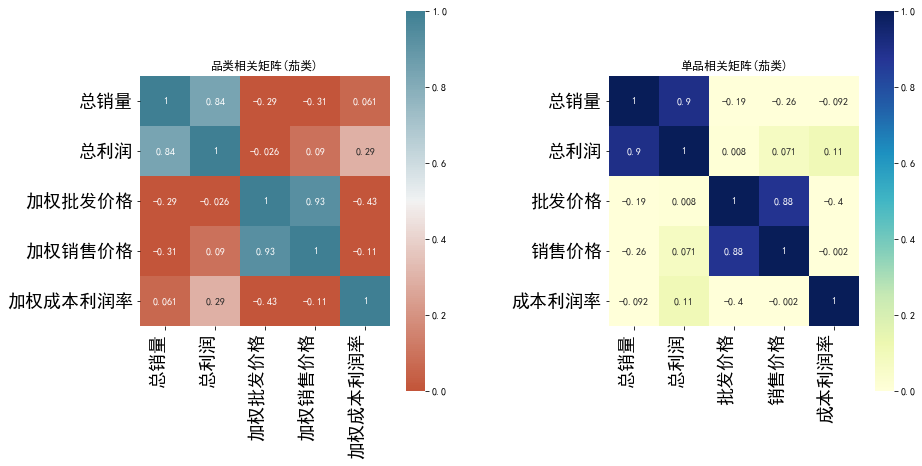

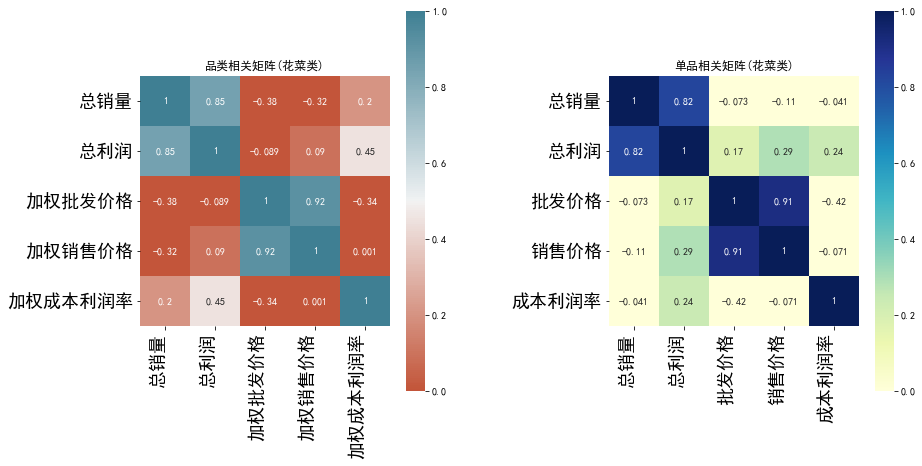

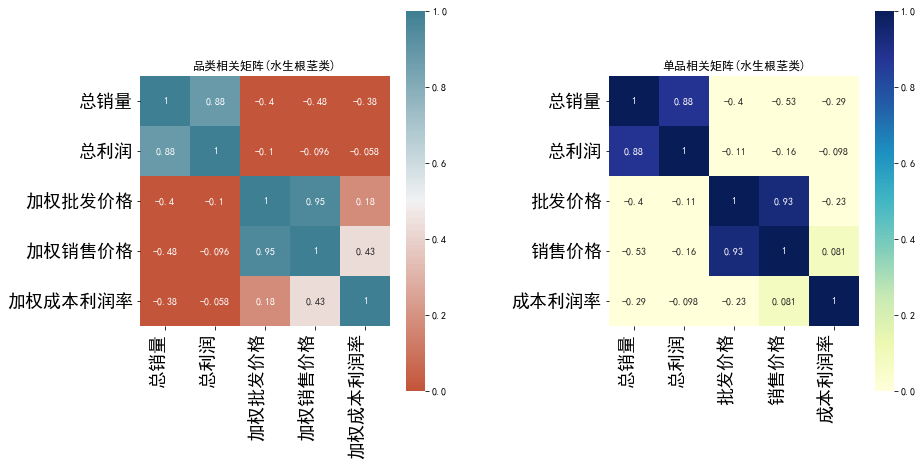

In [154]:
# 相关系数矩阵，分为品类和单品，聚合时可能会发生变化

# 遍历每个唯一的分类名称
for i in sales['分类名称'].unique():
    # 从销售数据中筛选出当前分类名称的记录
    sub_sales_pro = sales_pro[sales_pro.分类名称 == i]
    
    # 从销售数据中筛选出当前分类名称的记录
    sub_sales = sales[sales.分类名称 == i]

    # 计算Spearman相关系数矩阵并四舍五入保留三位小数
    corr = round(sub_sales_pro.corr(method='spearman'), 3)
    
    # 创建一个包含两个子图的画布
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(121)
    
    # 绘制左侧的相关系数矩阵热力图
    sns.heatmap(corr, annot=True, vmax=1, vmin=0, xticklabels=True, yticklabels=True, square=True, cmap=sns.diverging_palette(20, 220, n=200))
    ax1.set_yticklabels(corr.columns, fontsize=18, rotation=360, horizontalalignment='right')
    ax1.set_xticklabels(corr.columns, fontsize=18, horizontalalignment='right')
    ax1.set_title(f'品类相关矩阵({i})')

    ax2 = fig.add_subplot(122)
    
    # 选择要计算相关系数的列
    columns = ['总销量', '总利润', '批发价格', '销售价格', '成本利润率']
    
    # 计算Spearman相关系数矩阵并四舍五入保留三位小数
    corr = round(sub_sales[columns].corr(method='spearman'), 3)
    
    # 绘制右侧的相关系数矩阵热力图
    sns.heatmap(corr, annot=True, vmax=1, vmin=0, xticklabels=True, yticklabels=True, square=True, cmap="YlGnBu")
    ax2.set_yticklabels(columns, fontsize=18, rotation=360, horizontalalignment='right')
    ax2.set_xticklabels(columns, fontsize=18, rotation=90, horizontalalignment='right')
    plt.subplots_adjust(wspace=0.5)
    ax2.set_title(f'单品相关矩阵({i})')
    
    # 保存生成的热力图为图像文件
    plt.savefig(f'问题2\\利润销量相关系数热力图({i}).png', dpi=500, bbox_inches='tight')
    plt.show()


In [164]:
# 定义计算Spearman相关系数的函数
def calculate_spearman_correlation(X, Y):
    return stats.spearmanr(X, Y)[0]

# 定义计算Spearman相关系数p值的函数
def calculate_spearman_correlation_p(X, Y):
    return stats.spearmanr(X, Y)[1]

# 初始化存储结果的列表
name = []  # 存储分类名称
ls1 = []   # 存储品类加权成本利润率与其他指标的Spearman相关系数p值
ls2 = []   # 存储单品成本利润率与其他指标的Spearman相关系数p值

# 遍历每个唯一的分类名称
for i in sales['分类名称'].unique():
    t1 = []  # 用于存储品类加权成本利润率与其他指标的p值
    t2 = []  # 用于存储单品成本利润率与其他指标的p值
    
    # 从销售数据中筛选出当前分类名称的记录
    sub_sales_pro = sales_pro[sales_pro.分类名称 == i]
    
    # 从销售数据中筛选出当前分类名称的记录
    sub_sales = sales[sales.分类名称 == i]
    
    # 计算品类加权成本利润率与其他指标的Spearman相关系数p值
    for o in ['总销量', '总利润', '加权批发价格', '加权销售价格']:
        t1.append(calculate_spearman_correlation_p(sub_sales_pro['加权成本利润率'], sub_sales_pro[o]))
    
    # 计算单品成本利润率与其他指标的Spearman相关系数p值
    for o in ['总销量', '总利润', '批发价格', '销售价格']:
        t2.append(calculate_spearman_correlation_p(sub_sales['成本利润率'], sub_sales[o]))
    
    # 将结果存储到对应的列表中
    ls1.append(t1)
    ls2.append(t2)
    name.append(i)

# 创建数据框，将结果保存为Excel文件
pd.DataFrame(ls1, columns=['总销量', '总利润', '加权批发价格', '加权销售价格'], index=name).to_excel('问题2\\品类加权成本利润率斯皮尔曼检验.xlsx')
pd.DataFrame(ls2, columns=['总销量', '总利润', '批发价格', '销售价格'], index=name).to_excel('问题2\\单品成本利润率斯皮尔曼检验.xlsx')


对于最后一个问题，日补货总量和定价策略的确定，首先我们需要知道，补货总量是根据期望的需求制定的，而在不同的定价策略下，会有不同的需求值，所以我们需要先知道需求价格曲线，有了曲线过后，我们才能确定某个价格来使得自己的收益最大化。

In [ ]:
# 定义绘制需求价格曲线的函数
def function(data, name):
    # 使用线性回归建立价格和销售量的关系
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['总销量'], data['加权销售价格'])
    
    # 绘制两个子图
    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(25, 7))
    
    # 绘制销售价格的分布图
    sns.distplot(data['总销量'], ax=ax1, rug=True, bins=50)
    ax1.set_title(f'{name}价格分布', fontsize=18)
    ax1.tick_params(labelsize=14)
    ax1.set_xlabel(f'销售价格', fontsize=16)
    ax1.set_ylabel('密度', fontsize=16)

    # 绘制需求价格曲线图
    sns.regplot(x='总销量', y='加权销售价格', data=data, ax=ax2, line_kws={'label': "y={0:.3f}x+{1:.3f}\nR2={2:.3f}".format(slope, intercept, r_value**2)})
    ax2.set_title(f'{name}需求价格曲线', fontsize=18)
    ax2.tick_params(labelsize=14)
    ax2.set_xlabel(f'价格', fontsize=16)
    ax2.set_ylabel('总销量', fontsize=16)
    ax2.legend(fontsize='17')
    plt.legend(loc='upper right', fontsize=20)
    
    # 保存图片
    plt.savefig(f'问题2\\{name}需求价格曲线.png', dpi=500)
    plt.show()

# 针对每个唯一的分类名称，绘制需求价格曲线
for i in sales['分类名称'].unique():
    tem = sales_pro[sales_pro.分类名称 == i]
    function(tem, i)


In [ ]:
from datetime import datetime
from chinese_calendar import is_holiday, is_workday

# 创建空列表以存储日期相关信息
ls1 = []  # 是否工作日
ls2 = []  # 是否节假日
ls3 = []  # 季节信息

# 遍历销售日期，计算是否工作日、是否节假日和季节信息
for i in sales_pro['销售日期'].astype('str').values:
    ls1.append(int(is_workday(datetime.strptime(i, '%Y-%m-%d'))))
    ls2.append(int(is_holiday(datetime.strptime(i, '%Y-%m-%d'))))
    month = int(i[5:7])
    if month in [3, 4, 5]:
        ls3.append(0)  # 春季
    elif month in [6, 7, 8]:
        ls3.append(1)  # 夏季
    elif month in [9, 10, 11]:
        ls3.append(2)  # 秋季
    elif month in [12, 1, 2]:
        ls3.append(3)  # 冬季

# 将计算得到的日期相关信息添加到数据框中
sales_pro['是否工作日'] = ls1
sales_pro['是否节假日'] = ls2
sales_pro['春夏秋冬'] = ls3

# 为分类名称创建编码
sales_pro['分类名称_code'] = 0
n = 0 
for i in sales_pro['分类名称'].unique():
    sales_pro.loc[sales_pro.分类名称 == i, '分类名称_code'] = n
    n += 1

from sklearn.model_selection import train_test_split

# 定义特征和目标列
x = ['加权销售价格', '分类名称_code', '加权批发价格', '是否工作日', '是否节假日', '春夏秋冬']
y = ['总销量']

# 使用train_test_split函数划分数据集
xtrain, xvalid, ytrain, yvalid = train_test_split(sales_pro[x].values, sales_pro[y].values,
                                                  test_size=0.2)

# 创建随机森林回归模型并拟合数据
model = RandomForestRegressor(random_state=100)
model.fit(xtrain, ytrain)

# 打印模型在验证集上的R^2得分
print(model.score(xvalid, yvalid))

# 重新创建模型并使用整个数据集进行拟合
model = RandomForestRegressor(random_state=100)
model.fit(sales_pro[x].values, sales_pro[y].values)


Test Statistic: -2.337969
p-value: 0.160014
min aci: (3, 1, 3)


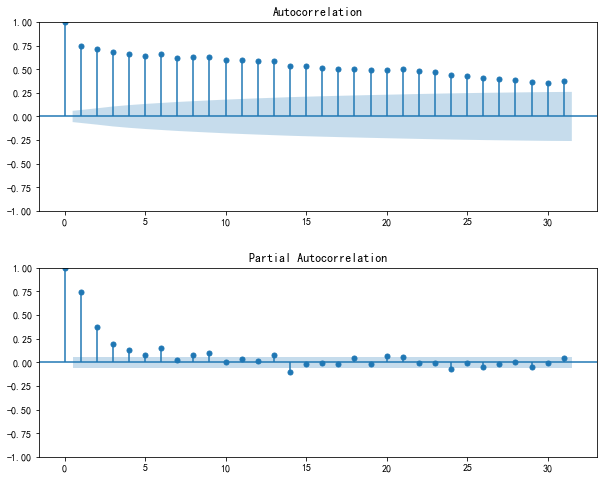

Test Statistic: -3.280195
p-value: 0.015787
min aci: (1, 1, 1)


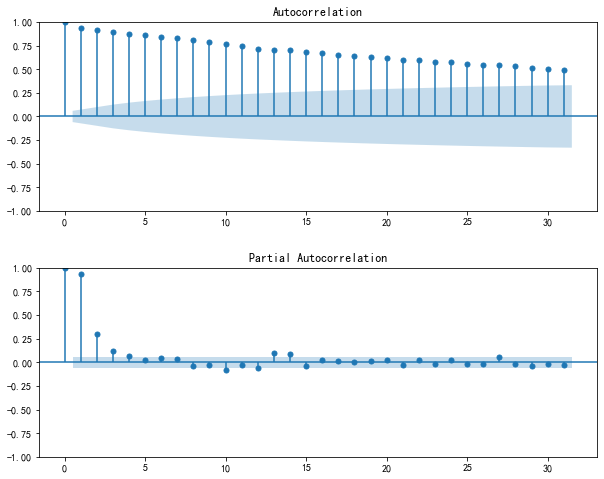

Test Statistic: -4.487570
p-value: 0.000207
min aci: (3, 1, 2)


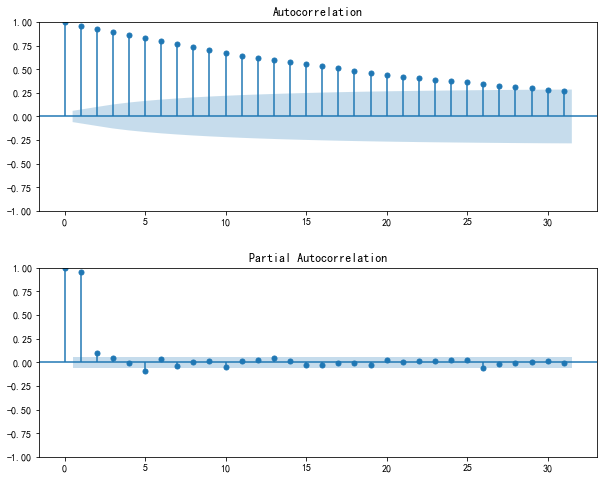

Test Statistic: -4.235372
p-value: 0.000574
min aci: (2, 1, 2)


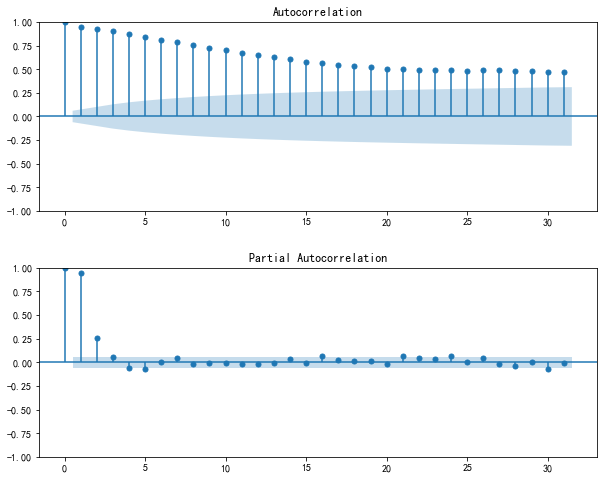

Test Statistic: -2.931902
p-value: 0.041762
min aci: (1, 1, 0)


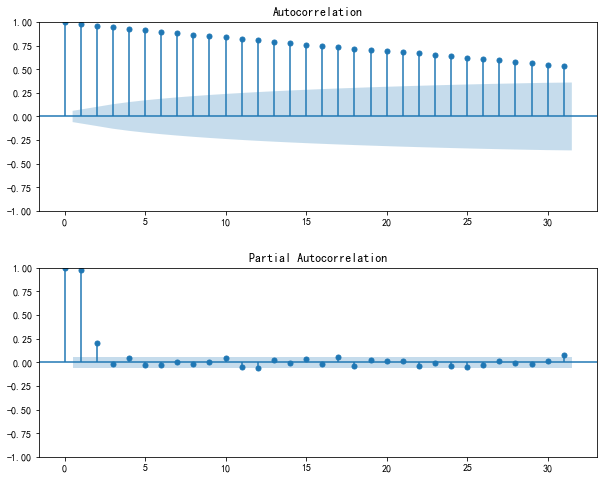

Test Statistic: -3.574731
p-value: 0.006263
min aci: (3, 1, 3)


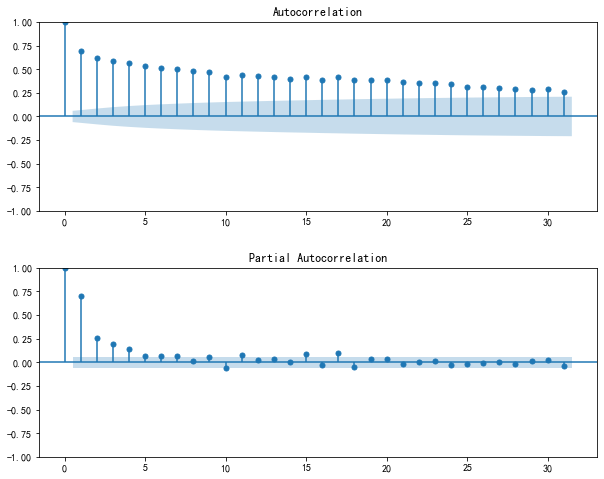

In [345]:
name = []  # 存储品类名称
predict = []  # 存储预测结果

# 遍历每个品类
for i in sales_pro['分类名称'].unique():
    tem = sales_pro[sales_pro.分类名称 == i]
    name.append(i)
    
    # 1. 读取csv时序数据
    data = tem['加权批发价格']
    data_origin = data.copy()

    # 2. 使用ADF测试数据是否稳定，如果不稳定进行一阶差分，并打印差分前和差分后的数据图。
    result = adfuller(data)
    print("Test Statistic: %f" % result[0])
    print("p-value: %f" % result[1])

    # 3. 对处理后数据进行归一化，打印归一化后的图。
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data.values.reshape(-1, 1)))

    # 4. 通过AIC确定ARIMA参数，打印原始数据和差分后数据的自相关系数图和偏自相关系数图，打印确定参数后的残差图。
    aic_values = {}
    for p in range(4):
        for q in range(4):
            try:
                model = ARIMA(scaled_data, order=(p, 1, q))
                result = model.fit()
                aic_values[(p, 1, q)] = result.aic
            except:
                continue

    min_aic = min(aic_values, key=aic_values.get)
    print("min AIC:", min_aic)

    # 绘制自相关和偏自相关图
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(scaled_data, ax=axes[0])
    plot_pacf(scaled_data, ax=axes[1])
    plt.subplots_adjust(hspace=0.3)
    plt.savefig(f'问题2\\{i}自相关偏自相关图.png', dpi=500)
    plt.show()

    # 5. 使用ARIMA模型进行预测，打印预测值和真实值的对比图，计算模型RMSE和MAPE指标。
    train_size = len(scaled_data) - 3
    train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
    model = ARIMA(train_data, order=min_aic)
    result = model.fit()
    predictions = result.forecast(steps=7)
    
    # 逆归一化预测结果
    predict.append(scaler.inverse_transform(predictions.values.reshape(-1, 1)).reshape(1, -1)[0])

# 创建包含品类名称和预测批发价格的结果数据框
result = pd.DataFrame({'品类名称': name, '预测批发价格': predict})


In [346]:
name = []  # 存储品类名称
date = ['2023-07-01', '2023-07-02', '2023-07-03', '2023-07-04',
        '2023-07-05', '2023-07-06', '2023-07-07']
ls1 = []  # 存储是否工作日的标志
ls2 = []  # 存储是否节假日的标志
ls3 = []  # 存储季节信息的标志（春夏秋冬）

# 遍历日期列表，计算是否工作日、是否节假日和季节信息
for i in date:
    ls1.append(int(is_workday(datetime.strptime(i, '%Y-%m-%d'))))
    ls2.append(int(is_holiday(datetime.strptime(i, '%Y-%m-%d'))))
    month = int(i[5:7])
    if month in [3, 4, 5]:
        ls3.append(0)  # 春季
    elif month in [6, 7, 8]:
        ls3.append(1)  # 夏季
    elif month in [9, 10, 11]:
        ls3.append(2)  # 秋季
    elif month in [12, 1, 2]:
        ls3.append(3)  # 冬季

# 创建一个空的数据框
dataset = pd.DataFrame()

# 遍历每个品类
for index, i in enumerate(sales_pro['分类名称'].unique()):
    name = [i for o in range(7)]  # 使用品类名称填充7天的数据
    date = ['2023-07-01', '2023-07-02', '2023-07-03', '2023-07-04',
            '2023-07-05', '2023-07-06', '2023-07-07']
    ls1 = []  # 存储是否工作日的标志
    ls2 = []  # 存储是否节假日的标志
    ls3 = []  # 存储季节信息的标志（春夏秋冬）
    
    # 遍历日期列表，计算是否工作日、是否节假日和季节信息
    for i in date:
        ls1.append(int(is_workday(datetime.strptime(i, '%Y-%m-%d'))))
        ls2.append(int(is_holiday(datetime.strptime(i, '%Y-%m-%d'))))
        month = int(i[5:7])
        if month in [3, 4, 5]:
            ls3.append(0)  # 春季
        elif month in [6, 7, 8]:
            ls3.append(1)  # 夏季
        elif month in [9, 10, 11]:
            ls3.append(2)  # 秋季
        elif month in [12, 1, 2]:
            ls3.append(3)  # 冬季
    
    # 创建临时数据框并将其与主数据框连接
    dataset = pd.concat([pd.DataFrame({'分类名称': name, '销售日期': date, '加权批发价格': predict[index],
                                       '是否工作日': ls1, '是否节假日': ls2, '春夏秋冬': ls3}), dataset])

# 为分类名称创建编码
dataset['分类名称_code'] = 0
n = 0 
for i in sales_pro['分类名称'].unique():
    dataset.loc[dataset.分类名称 == i, '分类名称_code'] = n
    n += 1

# 最终的数据框包含了品类名称、销售日期、加权批发价格、是否工作日、是否节假日、季节信息以及分类名称编码
dataset

,分类名称,销售日期,加权批发价格,是否工作日,是否节假日,春夏秋冬,分类名称_code
0,食用菌,2023-07-01,4.212516,0,1,1,5
1,食用菌,2023-07-02,4.240388,0,1,1,5
2,食用菌,2023-07-03,4.226087,1,0,1,5
3,食用菌,2023-07-04,4.250456,1,0,1,5
4,食用菌,2023-07-05,4.237946,1,0,1,5
5,食用菌,2023-07-06,4.259584,1,0,1,5
6,食用菌,2023-07-07,4.248705,1,0,1,5
0,辣椒类,2023-07-01,3.300932,0,1,1,4
1,辣椒类,2023-07-02,3.305848,0,1,1,4
2,辣椒类,2023-07-03,3.304782,1,0,1,4


In [359]:
need_ls = []  # 存储最佳补货量
price_ls = []  # 存储最佳定价策略
reward_ls = []  # 存储最佳预计收益

# 遍历数据集中的特征向量
for index, value in enumerate(dataset[x[1:]].values):
    best_price = 0
    best_reward = 0
    best_need = 0
    value = value.tolist()
    
    # 在一定范围内搜索最佳价格
    for price in np.arange(value[1] * 1.5, value[1] * 2, 0.1):
        i = [price] + value
        need = model.predict(np.array(i).reshape(1, -1))[0]  # 使用模型预测需求量
        reward = need * (i[0] - i[2])  # 计算预计收益
        if reward > best_reward:  # 如果当前收益最高
            best_reward = reward
            best_price = price
            best_need = need
    
    # 将最佳补货量、最佳定价策略和最佳预计收益添加到相应的列表中
    need_ls.append(best_need)
    price_ls.append(best_price)
    reward_ls.append(best_reward)

# 将最佳补货量、最佳定价策略和最佳预计收益添加到数据集中
dataset['补货量'] = need_ls
dataset['定价策略'] = price_ls
dataset['预计收益'] = reward_ls

# 将结果保存为Excel文件
dataset.to_excel('问题2\\价格和补货策略.xlsx', index=False)
